In [6]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import pygrib
import cfgrib
import glob
import sys
import stormeunice as eun

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Description

This script creaates a plot to disply the behaviour of the ensemble in terms of wind gusts and mean sea level pressure.

# Import data

In [2]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [3]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()

In [4]:
# EPS

directory = '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'
eps = []  # making sure to start from a clean slate

for ind, cont in enumerate(['cf', 'pf']):
    for files in glob.glob(directory+cont+'/*.nc'):
        print(files)
        if len(eps) == ind+1:
            data = xr.open_dataset(files)
            data = eun.data.Data.preproc_ds(data.get(['fg10', 'msl']))  # preprocessing just one variable for speed
            eps[ind] = xr.concat([eps[ind], data], dim = 'inidate')
        else:
            eps.append(eun.data.Data.preproc_ds(xr.open_dataset(files).get(['fg10', 'msl'])))

eps = xr.concat(eps, dim = 'number')

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc


# Calculate aggregated fields

In [18]:
ensmean_mslp = eps.sel(time = '2022-02-18 12').mean(dim = 'number').squeeze()

In [30]:
eps_friday = eps.sel(time = '2022-02-18 12')
enscount_fg10 = eps_friday.where(eps_friday.fg10 >= 22).count(dim = 'number').squeeze()

# Map

In [31]:
# wind gusts
full_map = [lon_min, lon_max, lat_min, lat_max]
fg10_box = full_map.copy()  #[-7, 2, 49, 54]  # lon_min, lon_max, lat_min, lat_max

# MSLP
msl_box = full_map.copy()  # [-6, 4, 52, 59]

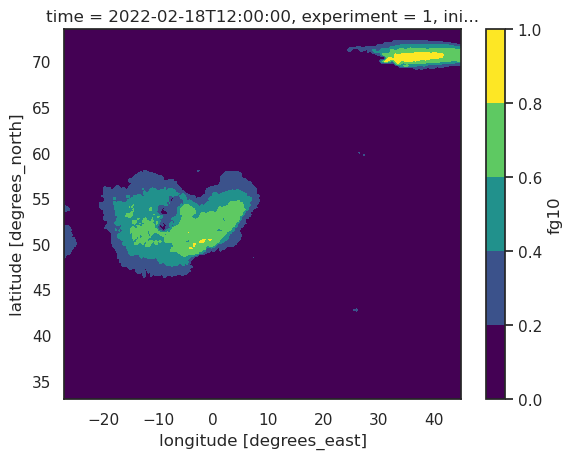

In [43]:
test = enscount_fg10.sel(inidate = inidate).fg10/51
test.plot.contourf()

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


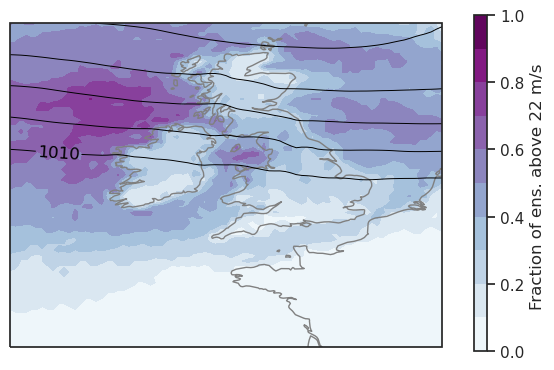

In [55]:
inidate = '2022-02-10'
projection = ccrs.PlateCarree()
p_max = 1010
p_min = 960

fg10_min = 0
fg10_max = 1

fg10_vals = enscount_fg10.sel(inidate = inidate).fg10.values/51
p_vals = ensmean_mslp.sel(inidate = inidate).msl.values[:,:]/100
longitude = ensmean_mslp.longitude.values
latitude = ensmean_mslp.latitude.values

# figure and map setup
fig = plt.figure(1)
ax = plt.subplot(111, projection = projection)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], projection)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

# isobars as contours
clevs_p = np.linspace(p_min, p_max, 12)
cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                transform=projection, linewidths = 0.7)
plt.clabel(cs, fmt='%d')

# fg10 as shading
clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)
cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                    transform=projection)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(cf, cax=cbar_ax, label='Fraction of ens. above 22 m/s ')

plt.savefig('figures/06_wind_threshold_exceedance_inidate-'+inidate+'.png')
plt.savefig('figures/06_wind_threshold_exceedance_inidate-'+inidate+'.pdf')